# Setup

In [96]:
import os
import json
import sys
sys.path.append('..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import open_clip
import torch

sys.path.append('../satclip')
sys.path.append('../satclip/satclip')
import satclip
from satclip.load import get_satclip
from huggingface_hub import hf_hub_download

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from utils import get_species_names, format_species_name_CLIP, get_species_embeddings, read_csv_non_utf, \
                  count_parameters, get_train_test_split, preprocess_data, get_zero_nonzero_datasets
from species_embeddings import multi_species_extraction

In [3]:
# Loading in general configuration
with open('../config.json', 'r') as f:
    config = json.load(f)

# Getting filepaths
gdrive_fp = config['gdrive_path']
LIFE_fp = config['LIFE_folder']
dataset_fp = config['datasets_path']

# Grabbing Benitez-Lopez
benitez_lopez2019 = config['indiv_data_paths']['benitez_lopez2019']
ben_lop_path = os.path.join(gdrive_fp, LIFE_fp, dataset_fp, benitez_lopez2019)
ben_lop2019 = read_csv_non_utf(ben_lop_path)

# Trying out BioCLIP and thinking about integration
- Relevant pages for BioCLIP
   - [`open_clip` package documentation - base package](https://pypi.org/project/open-clip-torch/)
   - [BioCLIP model page on HuggingFace](https://huggingface.co/imageomics/bioclip) 

In [3]:
# Testing out on a toy dataset of scientific names
sci_names = ['Loxodonta africana', 'Odocoileus virginianus', 'Pandinus imperator']

# Reading in the pre-trained BioCLIP model
model, _, preprocess_val = open_clip.create_model_and_transforms('hf-hub:imageomics/bioclip')
tokenizer = open_clip.get_tokenizer('hf-hub:imageomics/bioclip')

# Extracting the relevant info from ITIS
full_names = []
for name in sci_names:
    full_names.append(get_species_names(name))

In [4]:
# Processing with BioCLIP
species_embeddings = get_species_embeddings(full_names, model, tokenizer, full_hierarchy = True, common_name = False)

In [5]:
# Checking out the embeddings and the name strings that were processed
for k, v in species_embeddings.items():
    print(f'Species {k} has embedding of shape {v['embedding'].shape}')
    print(v['names_used'])
    print()

Species Loxodonta africana has embedding of shape (512,)
['a photo of Animalia Chordata Mammalia Proboscidea Elephantidae Loxodonta africana']

Species Odocoileus virginianus has embedding of shape (512,)
['a photo of Animalia Chordata Mammalia Artiodactyla Cervidae Odocoileus virginianus']

Species Pandinus imperator has embedding of shape (512,)
['a photo of Animalia Arthropoda Euchelicerata Scorpiones Scorpionidae Pandinus imperator']



In [6]:
# Seeing if elephants are more similar to deer than to scorpions as a basic sanity check
print(species_embeddings['Loxodonta africana']['embedding'].dot(species_embeddings['Odocoileus virginianus']['embedding']))
print(species_embeddings['Loxodonta africana']['embedding'].dot(species_embeddings['Pandinus imperator']['embedding']))

0.64558005
0.4450716


# Trying out SatCLIP for location embeddings

It's a little unclear if we want to use the model with $L=50$ or $L=10$; as mentioned in the paper, the latter is better for large-scale patterns and spatial generalization, while the former is better at capturing fine-grained patterns.

# Building a unified dataset
This is Benitez-Lopez 2019 with BioCLIP and SatCLIP embeddings.

## Utility functions

In [63]:
def get_record_species_embedding(species_list, embedding_dict):
    all_embeddings = np.array([embedding_dict[s]['embedding'] for s in species_list])
    mean_embedding = np.mean(all_embeddings, axis = 0)

    return mean_embedding

## Quality control on pre-computed species embeddings

In [64]:
# Reading in the saved embeddings
with open('../embeddings/bioclip_embeddings.json', 'r') as f:
    emb = json.load(f)

In [65]:
# Checking that all records are mammals
for name, dic in emb.items():
    for full_name in dic['names_used']:
        if 'Mammalia' not in full_name:
            print(name, full_name)

## Generating the dataset

In [121]:
# Getting the mean BioCLIP embedding for each record in the dataset
ben_lop2019_species = ben_lop2019['Species'].apply(multi_species_extraction)
mean_embs = ben_lop2019_species.apply(get_record_species_embedding, args = (emb, )).values
mean_embs = np.stack(mean_embs)

mean_embs.shape

(3281, 512)

In [74]:
# Getting the SatCLIP location embedding
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#  this only loads location encoder by default
model = get_satclip(
    hf_hub_download('microsoft/SatCLIP-ResNet50-L40', 'satclip-resnet50-l40.ckpt'),
    device = device,
)
model.eval()

# Loading Benitez-Lopez and extracting coordinates - inputs are (longitude, latitude)
coords = torch.from_numpy(ben_lop2019[['X', 'Y']].values).to(device)

# Processing using the pre-trained location embedder from SatCLIP
with torch.no_grad():
    coord_emb = model(coords).detach().cpu()
    coord_emb /= coord_emb.norm(dim = -1, keepdim = True) # vector norm to be consistent w/BioCLIP

coord_emb = coord_emb.numpy()
coord_emb.shape

using pretrained moco resnet50


(3281, 256)

In [104]:
# Combining embeddings into a unified dataframe
cols = [f'bioclip_{i}' for i in range(mean_embs.shape[1])]
species_emb_pd = pd.DataFrame(mean_embs, columns = cols)

cols = [f'satclip_{i}' for i in range(coord_emb.shape[1])]
coord_emb_pd = pd.DataFrame(coord_emb, columns = cols)

all_emb = pd.concat((species_emb_pd, coord_emb_pd), axis = 1)

In [113]:
# Writing a function to put everything together
idxs = get_train_test_split(len(mean_embs))
pp_data = preprocess_data(ben_lop2019, standardize = True, train_test_idxs = idxs)

train_data, test_data = pp_data.iloc[idxs['train']].copy(deep = True), pp_data.iloc[idxs['test']].copy(deep = True)    
X_zero, y_zero, X_nonzero, y_nonzero = get_zero_nonzero_datasets(train_data, pred = False, extirp_pos = False)

pd.concat((X_zero, all_emb.iloc[idxs['train']]), axis = 1)

,BM,DistKm,PopDens,Stunting,Reserve,bioclip_0,bioclip_1,bioclip_2,bioclip_3,bioclip_4,...,satclip_246,satclip_247,satclip_248,satclip_249,satclip_250,satclip_251,satclip_252,satclip_253,satclip_254,satclip_255
409,-0.267598,-0.366811,-0.366199,-0.909231,1,0.008605,0.065902,-0.031968,0.028904,-0.015659,...,0.025072,-0.064657,0.006053,-0.040490,-0.105010,0.011857,-0.015940,0.111122,-0.011060,-0.043822
1878,-0.267598,-0.670465,0.425574,-0.909231,0,0.008605,0.065902,-0.031968,0.028904,-0.015659,...,0.011735,-0.077165,0.026384,-0.028417,-0.087654,0.010204,-0.008961,0.123125,0.008557,-0.027998
2177,-0.261773,-0.716013,0.268699,0.022265,0,0.049511,0.038785,0.023129,0.028847,0.023333,...,0.041229,-0.107137,0.007700,-0.043493,-0.027374,-0.006582,-0.073686,0.067740,-0.095193,-0.091518
1339,-0.270004,2.718308,0.671082,1.446016,1,0.056565,0.050197,0.022339,0.044160,0.046241,...,0.010392,-0.110878,-0.121741,0.016643,-0.021134,-0.064399,-0.017096,-0.123600,-0.001776,0.015349
2601,-0.269132,0.392322,-0.233213,0.953762,1,0.079113,-0.010141,0.026370,-0.039059,0.024981,...,-0.040446,0.021199,0.084554,0.009593,-0.019301,0.027316,-0.021131,0.160112,-0.086437,-0.081864
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,-0.256809,-0.746378,-0.371463,0.173728,1,0.001201,0.012499,-0.005160,-0.001751,0.037262,...,0.090829,-0.074381,-0.040511,0.066558,0.058297,0.006200,-0.075761,-0.062443,0.027994,0.021964
1162,-0.270337,-0.721074,0.194126,1.764088,1,0.020750,0.057816,0.037504,0.001067,0.011467,...,-0.024369,-0.026398,0.081000,-0.011848,-0.026468,0.034103,-0.059776,0.089154,-0.082728,-0.090888
422,-0.113583,0.189887,-0.278229,1.771661,0,0.014703,0.000297,0.017552,-0.050135,-0.010070,...,-0.043268,0.000455,0.081912,0.010042,-0.032382,0.001771,-0.019368,0.167006,-0.083907,-0.065583
1282,-0.274238,-0.113767,-0.273591,0.128289,1,0.003508,-0.011426,0.036447,0.042072,0.022884,...,0.014406,-0.069093,0.023563,-0.005386,-0.106750,0.055826,0.020533,0.045768,-0.080639,-0.040831


In [156]:
# Helper function from StackOverflow: https://stackoverflow.com/questions/8391411/how-to-block-calls-to-print
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [159]:
def get_all_embeddings(ben_lop_data, pca = False, var_cutoff = 0.9, embeddings_to_use = None, train_test_idxs = None):

    if pca:
        assert train_test_idxs is not None, 'If performing PCA, please provide training and testing indices.'
    
    if embeddings_to_use is None:
        embeddings_to_use = ['SatCLIP', 'BioCLIP']
    
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    embeddings = []

    # Getting the SatCLIP location embedding
    if 'SatCLIP' in embeddings_to_use:
        #  this only loads location encoder by default
        with HiddenPrints():
            model = get_satclip(
                hf_hub_download('microsoft/SatCLIP-ResNet50-L40', 'satclip-resnet50-l40.ckpt'),
                device = device
            )
        model.eval()
        
        #  extracting coordinates - inputs are (longitude, latitude)
        coords = torch.from_numpy(ben_lop_data[['X', 'Y']].values).to(device)
        
        #  processing using the pre-trained location embedder from SatCLIP
        with torch.no_grad():
            coord_emb = model(coords).detach().cpu()
            coord_emb /= coord_emb.norm(dim = -1, keepdim = True) # vector norm to be consistent w/BioCLIP
        
        coord_emb = coord_emb.numpy()

        #  optionally applying PCA to reduce dimensionality of the embedding
        if pca:
            #  scaling the data (z-score normalization)
            scaler = StandardScaler()
            coord_emb_train = scaler.fit_transform(coord_emb[train_test_idxs['train']])
            coord_emb_test = scaler.transform(coord_emb[train_test_idxs['test']])

            #  performing PCA
            pca = PCA()
            coord_pca_train = pca.fit_transform(coord_emb_train)
            coord_pca_test = pca.transform(coord_emb_test)

            #  getting enough components to explain > var_cutoff variance
            exp_var = pca.explained_variance_ratio_.cumsum()
            idx_cutoff = np.argmax(exp_var > var_cutoff) + 1
            coord_emb = np.vstack((coord_pca_train[ : , : idx_cutoff], coord_pca_test[ : , : idx_cutoff]))

        #  putting into a dataframe
        cols = [f'satclip_{i}' for i in range(coord_emb.shape[1])]
        coord_emb_pd = pd.DataFrame(coord_emb, columns = cols)
        if pca:
            coord_emb_pd.index = list(train_test_idxs['train']) + list(train_test_idxs['test'])
            coord_emb_pd = coord_emb_pd.sort_index()

        embeddings.append(coord_emb_pd)

    # Getting the mean BioCLIP embedding for each record in the dataset
    if 'BioCLIP' in embeddings_to_use:
        #  reading in the saved embeddings
        with open('../embeddings/bioclip_embeddings.json', 'r') as f:
            bioclip_emb = json.load(f)

        #  getting embeddings for the dataset
        species = ben_lop_data['Species'].apply(multi_species_extraction)
        species_emb = species.apply(get_record_species_embedding, args = (bioclip_emb, )).values
        species_emb = np.stack(species_emb)

        #  optionally applying PCA to reduce dimensionality of the embedding
        if pca:
            #  scaling the data (z-score normalization)
            scaler = StandardScaler()
            species_emb_train = scaler.fit_transform(species_emb[train_test_idxs['train']])
            species_emb_test = scaler.transform(species_emb[train_test_idxs['test']])

            #  performing PCA
            pca = PCA()
            species_pca_train = pca.fit_transform(species_emb_train)
            species_pca_test = pca.transform(species_emb_test)

            #  getting enough components to explain > var_cutoff variance
            exp_var = pca.explained_variance_ratio_.cumsum()
            idx_cutoff = np.argmax(exp_var > var_cutoff) + 1
            species_emb = np.vstack((species_pca_train[ : , : idx_cutoff], species_pca_test[ : , : idx_cutoff]))

        #  putting into a dataframe
        cols = [f'bioclip_{i}' for i in range(species_emb.shape[1])]
        species_emb_pd = pd.DataFrame(species_emb, columns = cols)
        if pca:
            species_emb_pd.index = list(train_test_idxs['train']) + list(train_test_idxs['test'])
            species_emb_pd = species_emb_pd.sort_index()

        embeddings.append(species_emb_pd)

    # Combining embeddings into a unified dataframe
    all_emb = pd.concat(embeddings, axis = 1)

    return all_emb

In [160]:
df = get_all_embeddings(ben_lop2019, pca = True, train_test_idxs = idxs)

In [163]:
pd.concat((pp_data, df), axis = 1)

,BM,DistKm,PopDens,Stunting,TravTime,LivestockBio,Literacy,Reserve,ratio,satclip_0,...,bioclip_75,bioclip_76,bioclip_77,bioclip_78,bioclip_79,bioclip_80,bioclip_81,bioclip_82,bioclip_83,bioclip_84
0,-0.254195,-0.918449,-0.339808,-0.356392,-0.104626,-0.365333,-0.087275,0,0.377193,-0.674845,...,-0.518062,-0.458545,-1.279614,0.218407,-0.499588,0.753460,-0.342533,0.090540,-0.185373,-0.141378
1,4.560857,-0.918449,-0.339808,-0.356392,-0.104626,-0.365333,-0.087275,0,0.865690,-0.674845,...,-0.324971,-0.039037,-0.096265,0.053140,0.204656,-0.013582,-0.351999,0.029654,-0.211779,0.086341
2,-0.254195,-0.893144,-0.339808,-0.356392,-0.104626,-0.365333,-0.087275,0,0.833333,-0.674845,...,-0.518062,-0.458545,-1.279614,0.218407,-0.499588,0.753460,-0.342533,0.090540,-0.185373,-0.141378
3,4.560857,-0.893144,-0.339808,-0.356392,-0.104626,-0.365333,-0.087275,0,0.900862,-0.674845,...,-0.324971,-0.039037,-0.096265,0.053140,0.204656,-0.013582,-0.351999,0.029654,-0.211779,0.086341
4,-0.254195,-0.862779,-0.339808,-0.356392,-0.104626,-0.365333,-0.087275,0,0.956140,-0.674845,...,-0.518062,-0.458545,-1.279614,0.218407,-0.499588,0.753460,-0.342533,0.090540,-0.185373,-0.141378
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3276,-0.273275,0.453053,-0.183890,1.158236,-0.868944,-0.376377,-1.025693,1,1.000000,3.693891,...,1.246570,-0.390115,-1.143136,-0.257137,-1.457632,-1.075605,2.364899,-0.545777,-1.076565,0.695437
3277,1.464685,0.453053,-0.183890,1.158236,-0.868944,-0.376377,-1.025693,1,1.000000,3.693891,...,-0.676761,-0.613580,0.586221,-0.264048,-0.167410,0.812973,0.197190,0.047156,0.049293,-0.717306
3278,-0.193536,0.453053,-0.183890,1.158236,-0.868944,-0.376377,-1.025693,1,1.000000,3.693891,...,1.227884,-0.155208,0.012173,0.281814,-0.328161,2.008128,-0.150923,0.456920,0.619232,0.253084
3279,-0.173886,0.453053,-0.183890,1.158236,-0.868944,-0.376377,-1.025693,1,1.000000,3.693891,...,-0.834366,0.415249,-0.318601,1.021251,-0.366719,-0.705426,1.054150,0.313145,0.881525,-0.446426


## PCA experiments

84


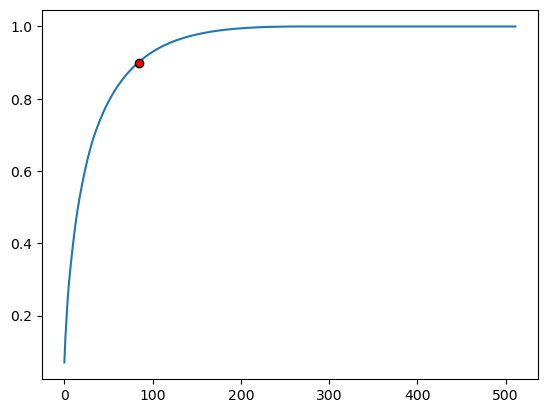

In [138]:
# BioCLIP: performing PCA on a toy train set
train_data = mean_embs[idxs['train'], : ]
test_data = mean_embs[idxs['test'], : ]

scaler = StandardScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

pca = PCA()
train_pca = pca.fit_transform(train_data)
test_pcs = pca.transform(test_data)

# Plotting explained variance
var_cutoff = 0.9
exp_var = pca.explained_variance_ratio_.cumsum()
idx_cutoff = np.argmax(exp_var > var_cutoff)
print(idx_cutoff)

plt.plot(exp_var, zorder = 0)
plt.scatter(idx_cutoff, var_cutoff, color = 'red', edgecolor = 'black', zorder = 100);

18


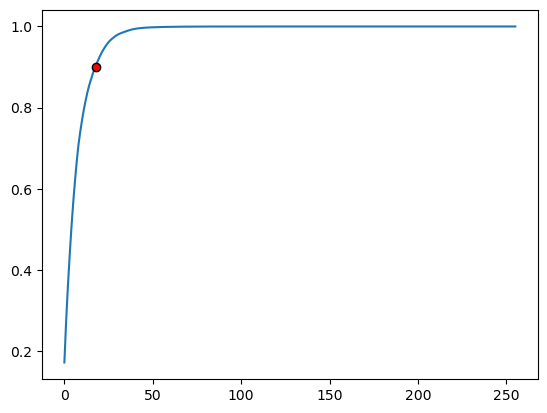

In [150]:
# SatCLIP: performing PCA on a toy train set
train_data = coord_emb[idxs['train'], : ]
test_data = coord_emb[idxs['test'], : ]

scaler = StandardScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

pca = PCA()
train_pca = pca.fit_transform(train_data)
test_pcs = pca.transform(test_data)

# Plotting explained variance
var_cutoff = 0.9
exp_var = pca.explained_variance_ratio_.cumsum()
idx_cutoff = np.argmax(exp_var > var_cutoff)
print(idx_cutoff)

plt.plot(exp_var, zorder = 0)
plt.scatter(idx_cutoff, var_cutoff, color = 'red', edgecolor = 'black', zorder = 100);